# Fitting a weight function to the Lamb-Oseen vortex

We assume that the Biot-Savart law can be written with a weight function like
$$
\vec u_w (\vec r) = \frac{\Gamma}{4 \pi} \oint_C \frac{\hat t \times \vec \xi(\ell)}{\|\vec \xi (\ell)\|^3} w\left(\tfrac{\Delta}{a}\right) d\ell
$$
where $a$ is the vortex core radius, $\vec \xi (\ell) = \vec r - \vec C(\ell)$ is the vector from $\vec C(\ell)$ to $\vec r$, $\Delta$ is some measure (chosen by us) of the distance between $\vec r$ and $\vec C(\ell)$, and $w$ is a weight function which is assumed to be zero when $\Delta = 0$ and one when $\Delta = \alpha a$ with $\alpha$ being an integer constant selected based on the problem.

**We want to fit our weight function such that when given a Lamb-Oseen vortex, we can recover the correct velocity field.** That is, $w\, | \, \vec u_w \approx \vec u_{LO}$

The velocity field of Lamb-Oseen vortex in cylindrical coordinates is given by
$$
\vec u_{LO}(s, \phi, z) = \frac{\Gamma}{2 \pi s} \left(1 - e^{-s^2 / a^2}\right) \hat \phi
$$

## Simplifying the Problem

Consider the Lamb-Oseen vortex be aligned with the $x$-axis and where $\Gamma = 1$ and $a = 1$.

The vortex is infinitely long, so $\vec u_{LO}$ is the same for any $z$, therefore we can set $z=0$ without loss of generality. The vortex also has axial symmetry, so we can set $\phi=0$, i.e., we evaluate the velocity only along the $y$-axis. Then the velocity will always be in the $\hat z$ direction, so we only evaluate the $z$-component of the velocity.

We will assume that $\Delta$ depends on the radial distance $\vec \xi$ like
$$
\Delta \equiv \| \vec \xi \|^2
$$
and that $a = 1$.

With the above we get
$$
\begin{align}
\ell &= x \\
\vec r &= y \hat y \\
\hat t &= \hat x \\
\vec C(x) &= x \hat x \\
\vec \xi(x) &= y \hat y - x \hat x \\
\|\vec \xi(x)\|^2 &= y^2 + x^2 \\
\hat x \times \vec \xi(x) &= y \hat z
\end{align}
$$
so we can rewrite the Bio-Savart law as
$$
u_w(y) = \frac{1}{4 \pi} \int_{-\infty}^\infty \frac{y}{(y^2 + x^2)^{3/2}} w\left(y^2 + x^2\right) dx
$$

When $w = 1$, we can evaluate the integral exactly as
$$
u_{w=1}(y) = \frac{1}{4 \pi} \frac{x}{y \sqrt{x^2 + y^2}} \Big|_{-\infty}^\infty = \frac{1}{2 \pi y} 
$$
where we assumed that $y > 0$ (i.e., real and positive). This is the expected result for an infinitesimally thin vortex filament. 

The velocity of the Lamb-Oseen vortex is
$$
u_{LO}(y) = \frac{1}{2 \pi y} \left(1 - e^{-y^2}\right)
$$



In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def u_LO(y):
    return (1 - np.exp(-y**2)) / (2 * np.pi * y)

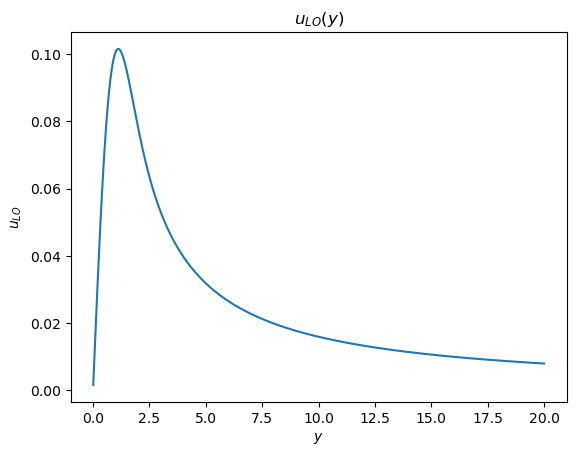

In [3]:
y_vec = np.linspace(0.01, 20, 1000)
u_LO_vec = u_LO(y_vec)
plt.plot(y_vec, u_LO_vec)
plt.title('$u_{LO}(y)$')
plt.xlabel('$y$')
plt.ylabel('$u_{LO}$')
plt.show()

## Weight Function

We will model the weight function as Bernstein polynomial, however, any other polynomial basis could be used.

A Bernstein polynomial of degree $n$ is given by
$$
B_n (x) = \sum_{k=0}^n \beta_k b_{k, n}(x)
$$
where \beta_k are the Bernstein coefficients (i.e., the coefficients we need to fit) and $b_{k, n}(x)$ are the Bernstein basis polynomials given by
$$
b_{k, n}(x) = \binom{n}{k} x^k (1 - x)^{n-k},\quad k = 0, 1, \ldots, n
$$
where $\binom{n}{k} = n!/k!(n-k)!$ is the binomial coefficient. Note, for a Bernstein polynomial of degree $n$, there are $n+1$ Bernstein basis polynomials.

**De Casteljau's algorithmt** is a numerically stable, recursive, algorithm for computing the Bernstein basis polynomials.

A Bernstein polynomial of degree $n$ can be evaluated at $x_0$ with the following
$$
\begin{align}
\alpha_i^{(0)} &= \beta_i && r=0; && i=0, \dots, n\\
\alpha_i^{(r)} &= \alpha_i^{(r-1)}(1-x_0) + \alpha_{i+1}^{(r-1)} x_0 && r=0,\dots,n; && i=0,\dots,n-r
\end{align}
$$
where $i$ indexes the control points and $r$ level of recurrence. $\beta_i$ is the $i$-th Bernstein coefficient.

The result $B(x_0)$ is given by
$$
B_n(x_0) = \alpha_0^{(n)}
$$
that is, the $n$-th recurrence of the $0$-th control point.

**The Implementation of De Casteljau's algorithm** will compute the recurrence levels in descending order and the control points in ascending order. That is, we start with $r = n$ and $i = 0$ and end with $r = 0$ and $i = n$.

In [57]:
class BernsteinPolynomial:
    def __init__(self, order):
        self.order = int(order)
        # Initialize the weights to all ones
        self.weights = np.ones(order + 1)
        # print('(DEBUG: BP class) self.weights (1) =', self.weights)
        
    # def __repr__(self):
    #     return f'BernsteinPolynomial({self.weights})'
    
    def set_weights(self, weights):
        self.weights = weights
        # print('(DEBUG: BP class) self.weights (2) =', self.weights)
        self.order = len(weights) - 1
    
    def __call__(self, x0):
        # print('(DEBUG) x0 =', x0)
        # print('(DEBUG) weights =', weights)
        alpha = np.zeros((self.order + 1, self.order + 1))
        # -1 because range does not include the last value
        for i in range(self.order, -1, -1):
            # print('(DEBUG) i =', i)
            # + 1 because range does not include the last value
            for r in range(0, self.order - i + 1):
                # print('(DEBUG) r =', r)
                if r == 0:
                    # print(f'(DEBUG) r==0, alpha[{r}, {i}] =' , self.weights[i])
                    # print('(DEBUG: BP class) self.weights (3) =', self.weights)
                    alpha[r, i] = self.weights[i]
                else:
                    alpha[r, i] = alpha[r - 1, i] * (1 - x0) + alpha[r-1, i + 1] * x0
        
        # print('(DEBUG) alpha =\n', alpha)
        return alpha[self.order, 0]           

In [58]:
bp = BernsteinPolynomial(4)
bp(0.5)

1.0

## Validating our Bernstein Polynomial Implementation

A Bernstein polynomial of degree $n$ is given by
$$
B_n (x) = \sum_{k=0}^n \beta_k b_{k, n}(x)
$$
Then the first $n=0, 1, 2, 3$ Bernstein polynomials are
$$
\begin{align}
B_0(x) &= \beta_0 \\
B_1(x) &= \beta_0 (1 - x) + \beta_1 x \\
B_2(x) &= \beta_0 (1 - x)^2 + \beta_1 \cdot 2x(1-x) + \beta_2 x^2 \\
B_3(x) &= \beta_0 (1 - x)^3 + \beta_1 \cdot 3x (1 - x)^2 + \beta_2 \cdot 3 x^2 (1 - x) + \beta_3 x^3 \\
B_4(x) &= \beta_0 (1 - x)^4 + \beta_1 \cdot 4x (1 - x)^3 + \beta_2 \cdot 6 x^2 (1 - x)^2 + \beta_3 \cdot 4 x^3 (1 - x) + \beta_4 x^4
\end{align}
$$


In [6]:
def BP2(x, beta):
    return beta[0] * (1 - x)**2 + beta[1] * 2 * x * (1 - x) + beta[2] * x**2

def BP4(x, beta):
    return beta[0] * (1 - x)**4 + beta[1] * 4 * x * (1 - x)**3 + beta[2] * 6 * x**2 * (1 - x)**2 + beta[3] * 4 * x**3 * (1 - x) + beta[4] * x**4

In [7]:
beta = np.arange(5)
x0 = 0.12
print(BP4(x0, beta))

0.48000000000000004


Error = 9.209666375651935e-16


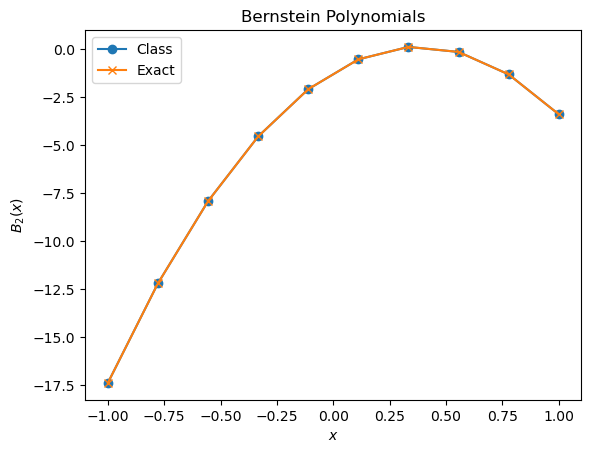

In [8]:
order = 2
x_vec = np.linspace(-1, 1, 10)
beta = [-1.2, 2.3, -3.4]
bp = BernsteinPolynomial(order)
bp.set_weights(beta)
y_vec = np.array([bp(x) for x in x_vec])
y_vec_exact = BP2(x_vec, beta)
print('Error =', np.linalg.norm(y_vec - y_vec_exact))
plt.plot(x_vec, y_vec, 'o-', label='Class')
plt.plot(x_vec, y_vec_exact, 'x-', label='Exact')
plt.legend()
plt.title('Bernstein Polynomials')
plt.xlabel('$x$')
plt.ylabel('$B_2(x)$')
plt.show()

beta = [-9.52448763  5.54194499  1.96672078  3.73150341  7.85232538]
Error = 5.902378311055886e-14


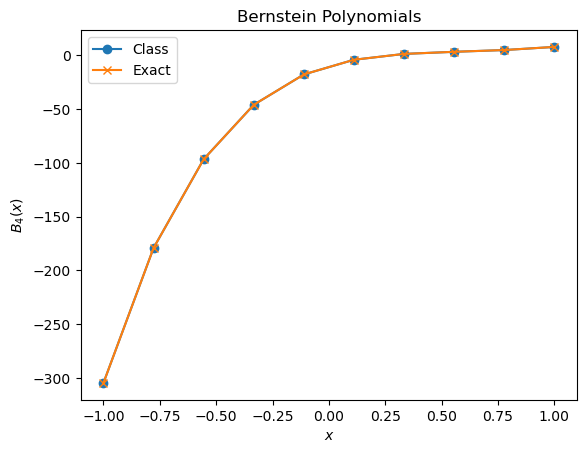

In [9]:
order = 4
x_vec = np.linspace(-1, 1, 10)
beta = np.random.default_rng().uniform(-10, 10, order + 1)
print('beta =', beta)
bp = BernsteinPolynomial(order)
bp.set_weights(beta)
y_vec = np.array([bp(x) for x in x_vec])
y_vec_exact = BP4(x_vec, beta)
print('Error =', np.linalg.norm(y_vec - y_vec_exact))
plt.plot(x_vec, y_vec, 'o-', label='Class')
plt.plot(x_vec, y_vec_exact, 'x-', label='Exact')
plt.legend()
plt.title('Bernstein Polynomials')
plt.xlabel('$x$')
plt.ylabel('$B_4(x)$')
plt.show()

## Validating method for integrating the Bio-Savart law

Consider an infinitely long infinitesimally thin vortex filament aligned with the $x$-axis. The velocity field is given by
$$
\vec u_{0true}(y) = \frac{1}{2 \pi y} \hat z
$$
where $y$ is the distance from the vortex filament.

The Bio-Savart law is the same as before except we set the weight function to one, i.e., $w = 1$, thus
$$
u_w(y) = \frac{1}{4 \pi} \int_{-\infty}^\infty \frac{y}{(y^2 + x^2)^{3/2}} dx
$$

In [10]:
# Unweighted Bio-Savart law for testing integration method
def u_0(y):
    def integrand(x, y):
        # x & y can be floats or arrays
        return y /  (y**2 + x**2)**(3/2)
        
    # Integration by scipy.integrate.quad
    return sp.integrate.quad(integrand, -np.inf, np.inf, args=(y))[0] / (4 * np.pi)
        


Error = 1.422726685315479e-13


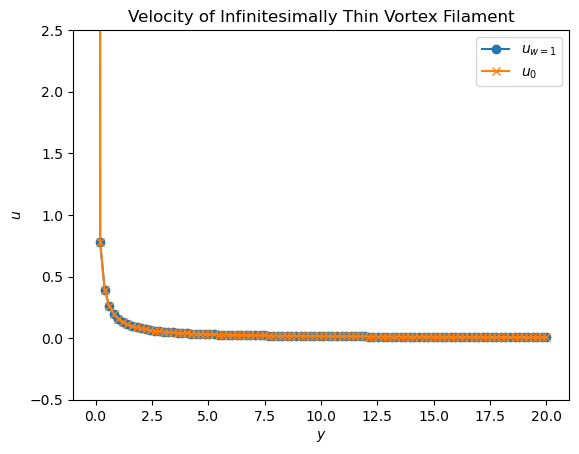

In [11]:
y_vec = np.linspace(0.001, 20, 100)
u_0true_vec = 1 / (2 * np.pi * y_vec)
u_0_vec = []
for i in range(len(y_vec)):
    u_0_vec.append(u_0(y_vec[i]))

u_0_vec = np.array(u_0_vec)

print('Error =', np.linalg.norm(u_0_vec - u_0true_vec))

plt.plot(y_vec, u_0_vec, 'o-', label='$u_{w=1}$')
plt.plot(y_vec, u_0true_vec, 'x-', label='$u_0$')
plt.legend()
plt.title('Velocity of Infinitesimally Thin Vortex Filament')
plt.xlabel('$y$')
plt.ylabel('$u$')
plt.ylim([-.5, 2.5])
plt.show()

## Fitting the Weight Function

We will use `scipy.optimize.curve_fit` to fit the weight function.

Using the variable names from the documentation (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)):
- ~~`f` is the function we want to fit, i.e., the weighted Biot-Savart law~~
- ~~`xdata` is an array of the independent variables where the data is measured, i.e., values of $y$ given to the weighted Biot_Savart law~~
- ~~`ydata` is an array of the data we want to fit our function to, i.e., the velocity of the Lamb-Oseen vortex in the $\hat z$ direction.~~
- ~~`p0` is an initial guess for the parameters of the function we want to fit. We should not need to provide this because the number of parameters is determined when the weight function is initialized.~~

In [59]:
order = 4
wf = BernsteinPolynomial(order)

In [73]:
# Bio-Savart law with Bernstein polynomial weight function
def u_w(y, *weights):
    # print('(DEBUG: u_w) weights =', weights)
    try:
        len(y)
    except TypeError:
        # print('(DEBUG: u_w) weights =', weights)
        w = np.asanyarray(weights)
        def integrand(x, y, w):
            # x & y can be floats or arrays
            # print('(DEBUG: u_w: integrand) w =', w)
            wf.set_weights(w)
            # print('(DEBUG: u_w: integrand) y**2=', y**2)
            # print('(DEBUG: u_w: integrand) x**2=', x**2)
            # print('(DEBUG: u_w) wf(y**2 + x**2) =', wf(y**2 + x**2))
            return y * wf(y**2 + x**2) /  (y**2 + x**2)**(3/2)
            
            # # Integration by scipy.integrate.quad
        return sp.integrate.quad(integrand, -np.inf, np.inf, args=(y, w))[0] / (4 * np.pi)
    else:
        u_w_vec = []
        for i in range(len(y)):
            u_w_vec.append(u_w(y[i], *weights))
        
        return np.array(u_w_vec)



Error = 1.422726685315479e-13


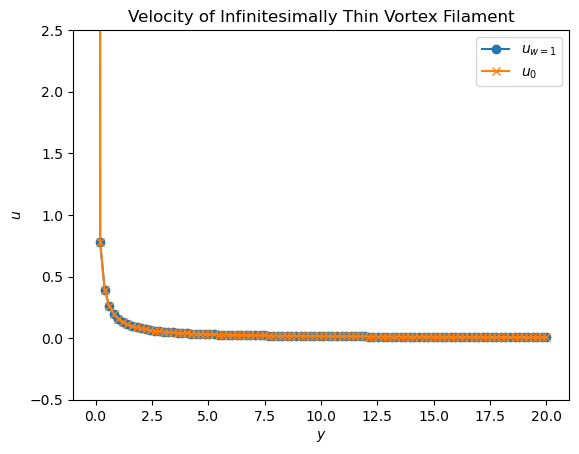

In [62]:
# Testing that the Bio-Savart law with the weight function works

y_vec = np.linspace(0.001, 20, 100)
u_0true_vec = 1 / (2 * np.pi * y_vec)

# NOTE: A Bernstein polynomial of degree n whose 
# coefficients are all one is a constant function
# of one.
w = np.ones(order + 1)
# u_w_vec = []
# for i in range(len(y_vec)):
#     # print('(DEBUG) w =', w)
#     u_w_vec.append(u_w(y_vec[i], *w))
# u_w_vec = np.array(u_0_vec)

# The *w to unpack the weights
# print('(DEBUG) wf.weights =', wf.weights)
u_w_vec = u_w(y_vec, *w)

print('Error =', np.linalg.norm(u_w_vec - u_0true_vec))

plt.plot(y_vec, u_w_vec, 'o-', label='$u_{w=1}$')
plt.plot(y_vec, u_0true_vec, 'x-', label='$u_0$')
plt.legend()
plt.title('Velocity of Infinitesimally Thin Vortex Filament')
plt.xlabel('$y$')
plt.ylabel('$u$')
plt.ylim([-.5, 2.5])
plt.show()


In [69]:
# Fitting the weight function to the Lamb-Oseen vortex

y_vec = np.linspace(0.001, 20, 100)

u_LO_vec = u_LO(y_vec)

# Reinitalize the weight function
order = 7
wf = BernsteinPolynomial(order)

# Initial guess for the weight function.
# Maybe try random initialization?
w0 = np.random.default_rng().uniform(-10, 10, order + 1)
print('w0 =', w0)
optw = sp.optimize.curve_fit(u_w, y_vec, u_LO_vec, p0=w0)[0]

w0 = [-4.22239498  1.23132026  6.82258843  6.17843142  6.29393884  8.77172547
  6.74551678 -2.83790968]


/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_54956/1113301630.py:19: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return sp.integrate.quad(integrand, -np.inf, np.inf, args=(y, w))[0] / (4 * np.pi)
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_54956/1113301630.py:19: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return sp.integrate.quad(integrand, -np.inf, np.inf, args=(y, w))[0] / (4 * np.pi)
/var/folders/pz/wy3lg_ps0fg986p2nzxcqlf00000gp/T/ipykernel_54956/1113301630.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  loca

In [72]:
print(w0 - optw)

[ 0.00000000e+00 -4.21884749e-15  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.30708866e-07  0.00000000e+00  0.00000000e+00]
